In [3]:
import numpy as np

def IteratedLocalSearch(initial_solution, parallel, slv):
    solution = np.array(list(map(np.array, initial_solution)))
    old_cost = slv.solution_cost(solution)
    solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, 
                           cost=slv.solution_cost, parallel=parallel, slv=slv)
    while old_cost > slv.solution_cost(solution):
        old_cost = slv.solution_cost(solution)
        solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, 
                               cost=slv.solution_cost, parallel=parallel, slv=slv)
    saved_solution = np.array([np.copy(route) for route in solution])
    saved_cost = slv.solution_cost(saved_solution)
    for i in range(10):
        print('    Perturbing...')
        Perturbation(solution)
        n = 0
        old_cost = slv.solution_cost(solution)
        while not slv.is_solution_feasible(solution) or old_cost > saved_cost:
            n += 1
            old_cost = slv.solution_cost(solution)
            solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, 
                                   cost=slv.solution_cost, parallel=parallel, slv=slv)
            if old_cost == slv.solution_cost(solution):
                print('    Local minimum is reached')
                break
        if old_cost < saved_cost:
            saved_solution = np.array([np.copy(route) for route in solution])
            saved_cost = slv.solution_cost(saved_solution)
        else:
            solution = np.array([np.copy(route) for route in saved_solution])
        print('    Search ended after {} iterations, current cost = {}'.format(n, old_cost))
    print('Search ended, final cost = {}'.format(saved_cost))
    return saved_solution


def GuidedLocalSearch(initial_solution, l, parallel, slv):
    solution = np.array(list(map(np.array, initial_solution)))
    penalties = {i: 0 for i in slv.distances}
    
    ultrapenalty = sum((penalties[i] for i in solution_edges(initial_solution)))
    old_cost = slv.solution_cost(solution) + ultrapenalty
    solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, cost=slv.solution_cost, 
                           parallel=parallel, slv=slv)
    update_penalties(solution, penalties)
    ultrapenalty = l * sum((penalties[i] for i in solution_edges(solution)))
    print(old_cost, ultrapenalty, slv.solution_cost(solution) + ultrapenalty)
    while old_cost > slv.solution_cost(solution) + ultrapenalty:
        old_cost = slv.solution_cost(solution) + ultrapenalty
        solution = LocalSearch(solution, is_feasible=slv.is_solution_feasible, cost=slv.solution_cost,
                               parallel=parallel, slv=slv)
        update_penalties(solution, penalties)
        ultrapenalty = l * sum((penalties[i] for i in solution_edges(solution)))
        print(old_cost, ultrapenalty, slv.solution_cost(solution) + ultrapenalty)
    saved_solution = np.array([np.copy(route) for route in solution])
    saved_cost = slv.solution_cost(saved_solution)
    print('Search ended, final cost = {}'.format(saved_cost))
    return saved_solution

        
def LocalSearch(solution, is_feasible, cost, parallel, slv):
    def _2op_move(route, slv):
        def after_swap_cost(route, client_i, client_2i, slv):
            route[client_i], route[client_2i] = route[client_2i], route[client_i]
            slv.recount_arrivals([route])
            cost = slv.route_cost(route)
            is_feasible = slv.check_time_windows(route) and slv.check_late_to_depot(route)
            return cost, is_feasible
        if len(route) < 4:
            return route
        swaps = [(i+1, j+i+1) for i in range(len(route[1:-2])) for j in range(len(route[i+1:-1])) if i+1 != j+i+1]
        swaps_cost_and_feasibility = [after_swap_cost(np.copy(route), i, j, slv) for i, j in swaps]
        swaps_cost = [(i, cost) for i, (cost, fsbl) in enumerate(swaps_cost_and_feasibility) if fsbl]
        current_cost = slv.route_cost(route)
        
        if len(swaps_cost) == 0:
            slv.recount_arrivals([route])
            return route
        best_swap = min(swaps_cost, key=lambda x: x[1])
        if current_cost <= best_swap[1]:
            slv.recount_arrivals([route])
            return route
        client_2i, client_i = swaps[best_swap[0]]
        route[client_i], route[client_2i] = route[client_2i], route[client_i]
        slv.recount_arrivals([route])
        return route
    
    old_cost = cost(solution)
    new_solution = np.array(parallel(joblib.delayed(_2op_move)(np.copy(route), slv) for route in solution))
    slv.recount_arrivals(new_solution)
    # print(is_feasible(new_solution), old_cost, cost(new_solution))
    if old_cost <= cost(new_solution):
        return solution
    else:
        return new_solution


def Perturbation(solution):
    def double_bridge(route):
        subroutes = np.array_split(route[1:-1], 4)
        for i in subroutes:
            i[0], i[-1] = i[-1], i[0]
        return np.hstack([0] + subroutes + [0])
    
    route_i = np.random.randint(0, len(solution))
    while len(solution[route_i]) <= 9:
        route_i = np.random.randint(0, len(solution))
    route = solution[route_i]
    solution[route_i] = double_bridge(route)

    Instance C108



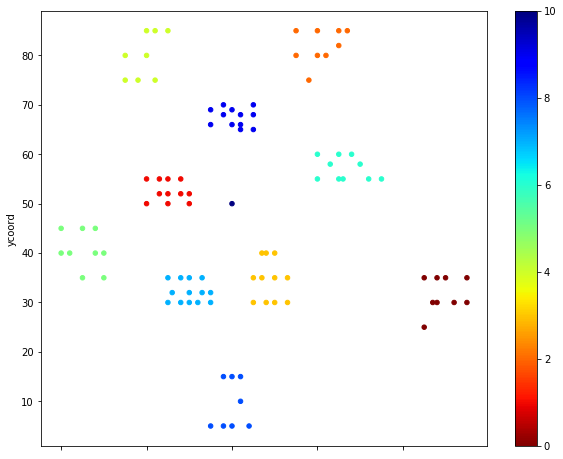


    Initial solution: 
        number of vehicles = 11
        cost = 974.1132163228089
        feasible = True
    
    Initial graph


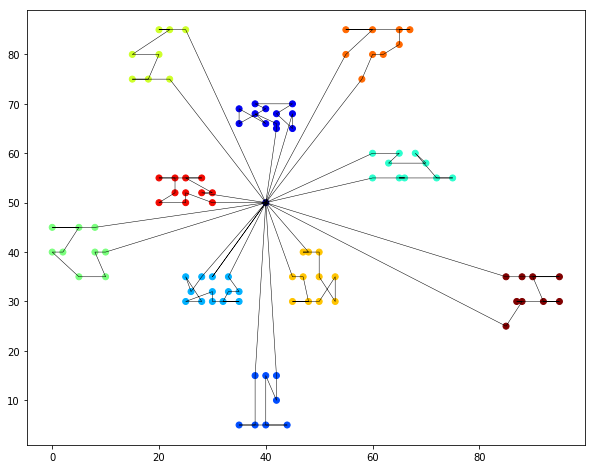

    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 864.1739960324524
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 894.9675133272069
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 880.9137168642399
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 884.8020087870436
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 884.8020087870436
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 887.901292904493
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 887.901292904493
    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 864.1739960324524
    Perturbing...
    Local minimum is reached
    Search ended af

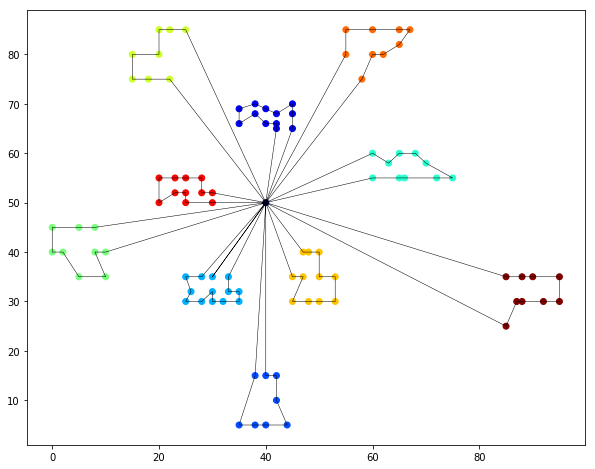

    Instance C203



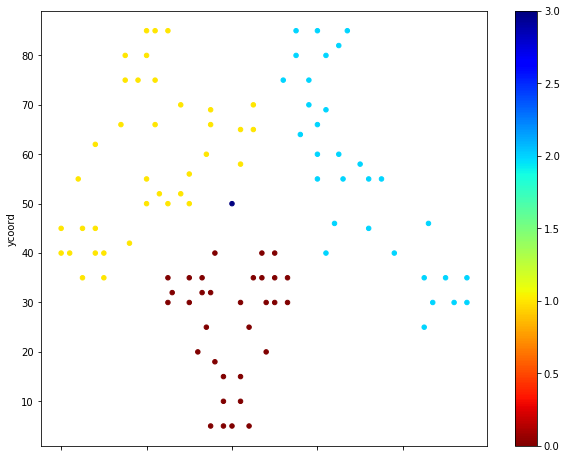


    Initial solution: 
        number of vehicles = 5
        cost = 1413.5828812355714
        feasible = True
    
    Initial graph


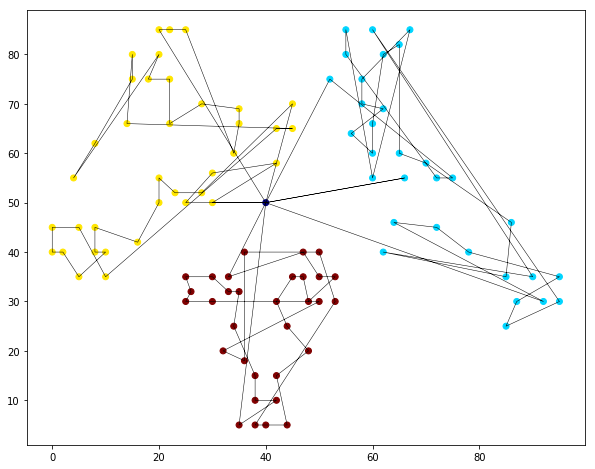

    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1161.5003967505088
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1035.1146095014
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1035.1146095014
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1201.0409885588215
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1161.5003967505088
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1161.5003967505088
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1161.5003967505088
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1035.1146095014
    Perturbing...
    Local minimum is reached
    Search ended a

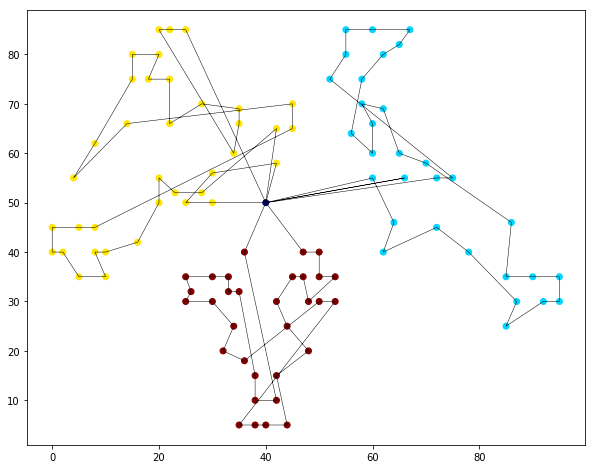

    Instance c2_4_9



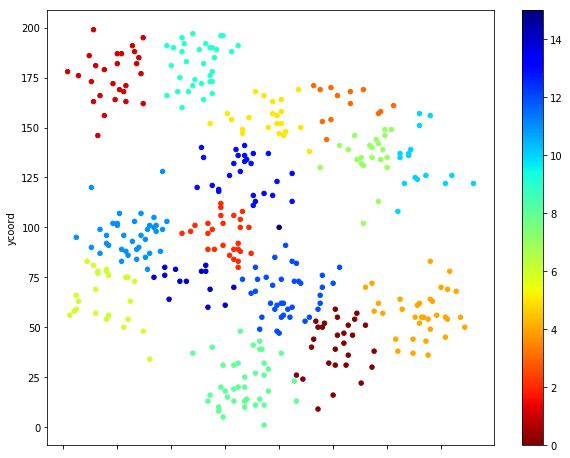


    Initial solution: 
        number of vehicles = 24
        cost = 8436.900295707732
        feasible = True
    
    Initial graph


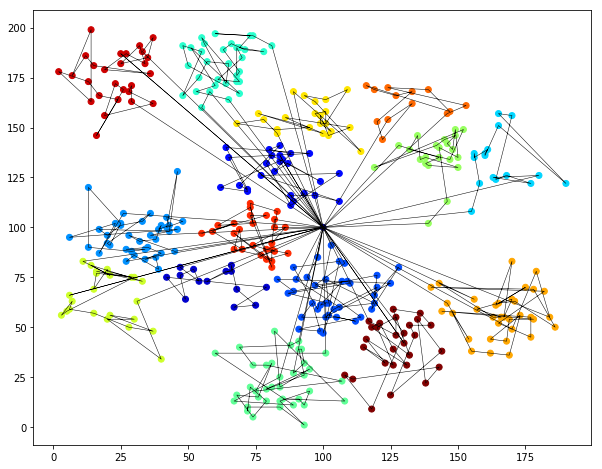

    Perturbing...
    Search ended after 5 iterations, current cost = 6446.474238521077
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6567.581158169805
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6604.20984168617
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6543.820033877328
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6479.866832982108
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6570.932612903056
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6526.677540022739
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 6643.884278653655
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current co

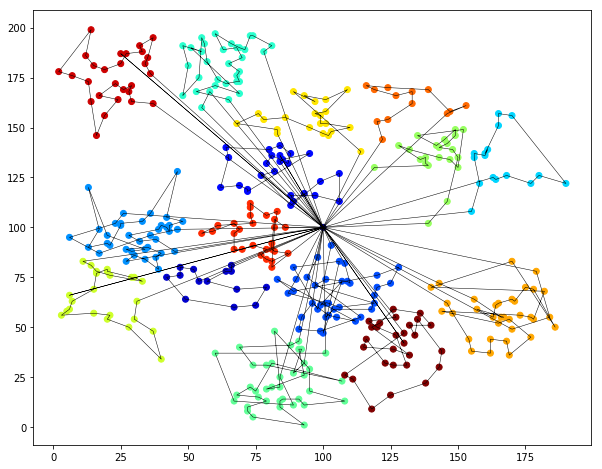

    Instance c2_6_6



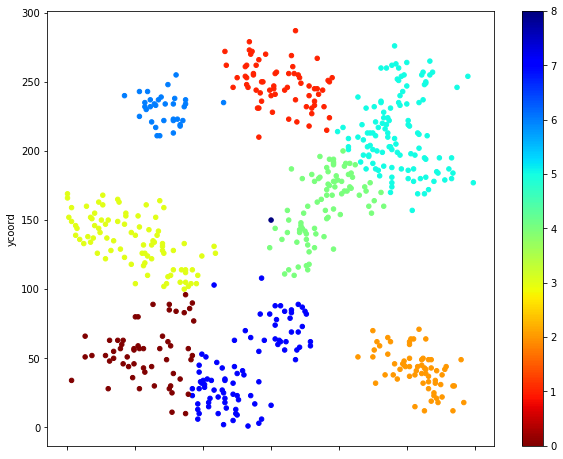


    Initial solution: 
        number of vehicles = 28
        cost = 20371.381120297097
        feasible = True
    
    Initial graph


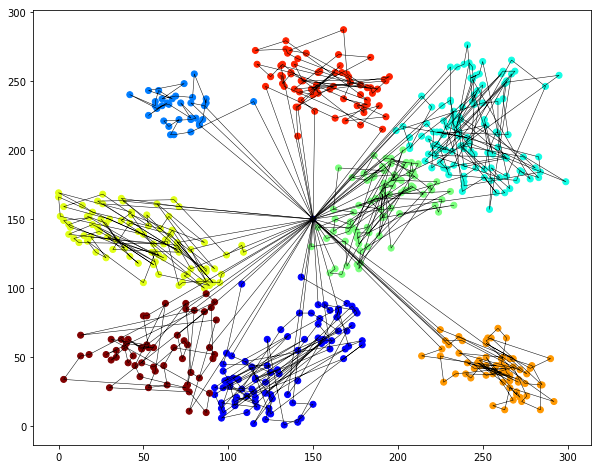

    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17572.437009438116
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17952.65184024905
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17668.35405732935
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17570.418850940165
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17506.394470969335
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17677.107366826258
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17684.19888482861
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 17600.31224051326
    Perturbing...
    Local minimum is reached
    Search en

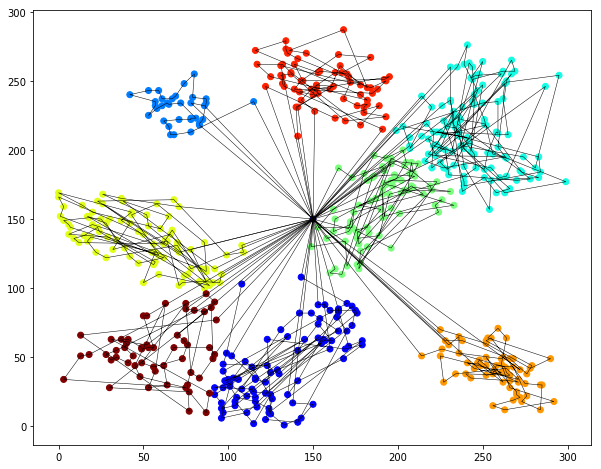

    Instance r1_4_6



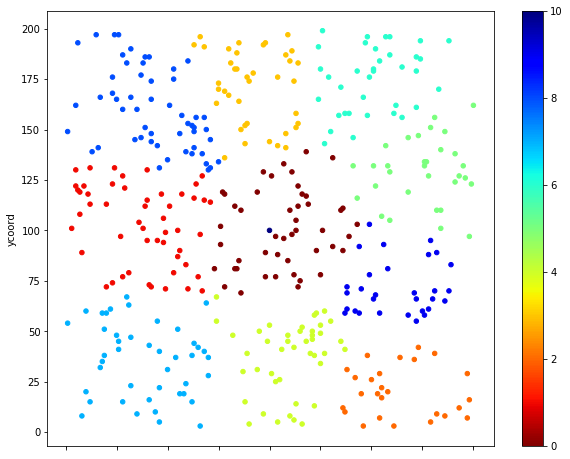


    Initial solution: 
        number of vehicles = 48
        cost = 14818.533202051514
        feasible = True
    
    Initial graph


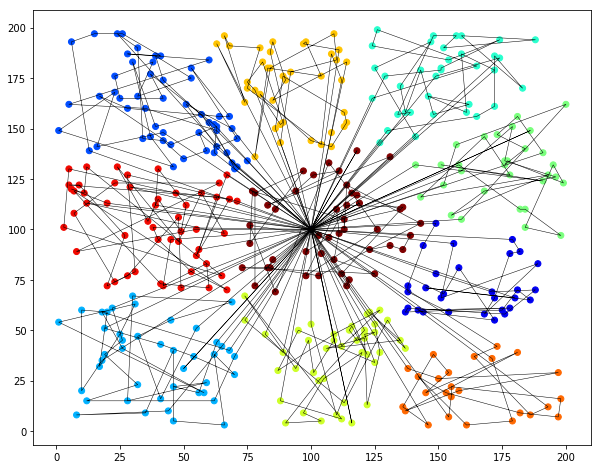

    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 13915.015057444507
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 13984.136388907516
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 13973.337391488914
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 14048.45373530278
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 13906.341770345922
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 13873.053792983965
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 13905.996620839249
    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 13846.057544196326
    Perturbing...
    Local minimum is reached
    Search

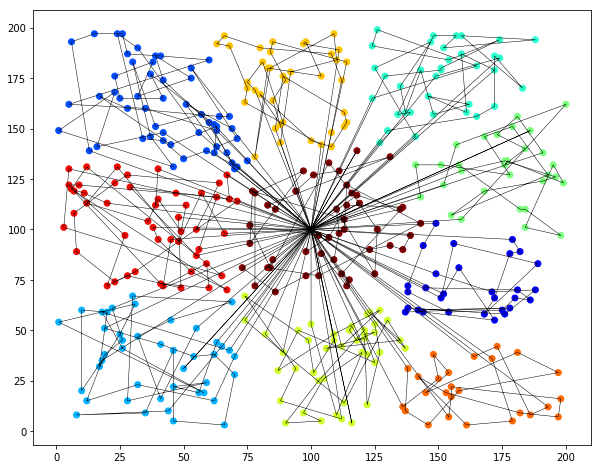

    Instance r1_6_8



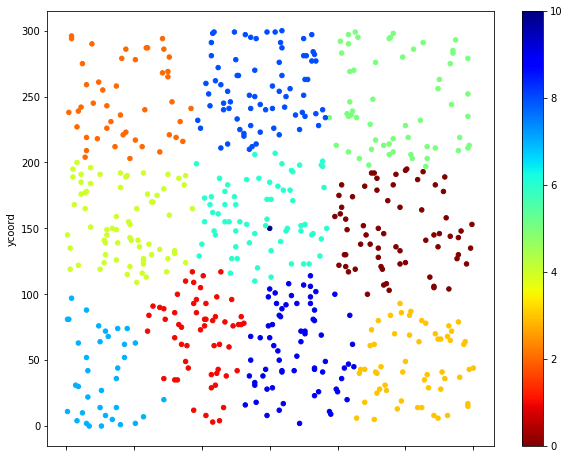


    Initial solution: 
        number of vehicles = 60
        cost = 23336.641938129385
        feasible = True
    
    Initial graph


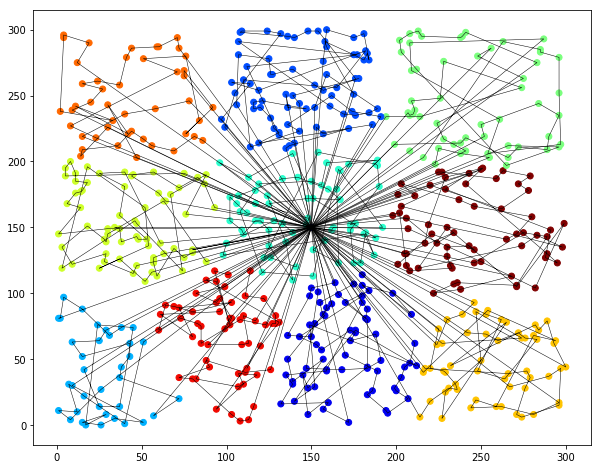

    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 22664.467104058334
    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 22664.467104058334
    Perturbing...
    Search ended after 4 iterations, current cost = 22659.86874789717
    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 22666.738003070568
    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 22656.865121095463
    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 22656.865121095463
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 22778.60055345008
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 22708.582172669943
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, cur

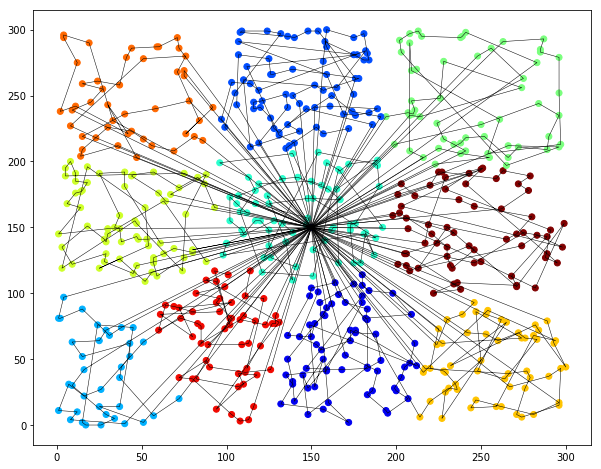

    Instance R202



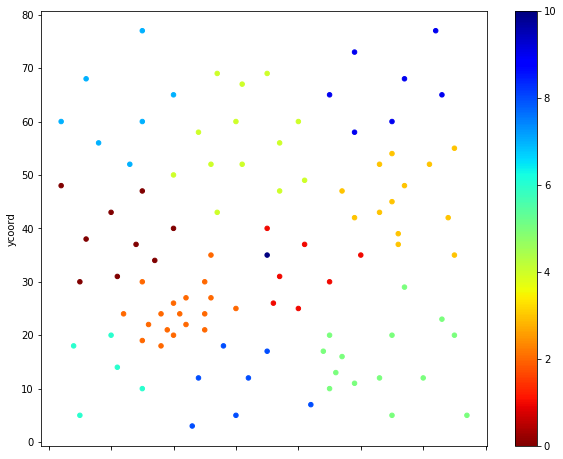


    Initial solution: 
        number of vehicles = 10
        cost = 1486.7044361010494
        feasible = True
    
    Initial graph


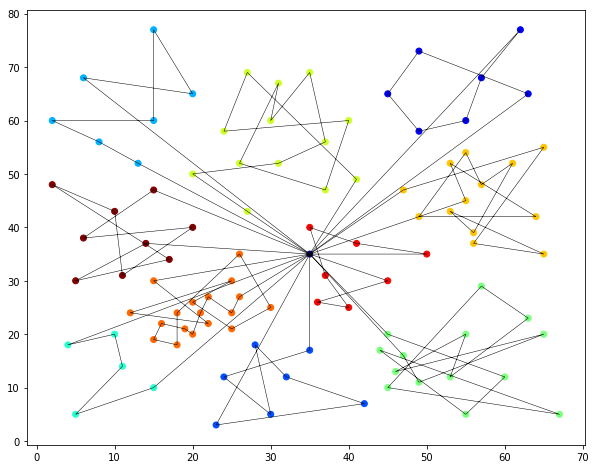

    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 1338.4023768815548
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1367.0455684587807
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1379.5374256576163
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1379.5374256576163
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1379.5374256576163
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1333.3977381874327
    Perturbing...
    Local minimum is reached
    Search ended after 5 iterations, current cost = 1333.3977381874327
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1364.7984789255108
    Perturbing...
    Local minimum is reached
    Searc

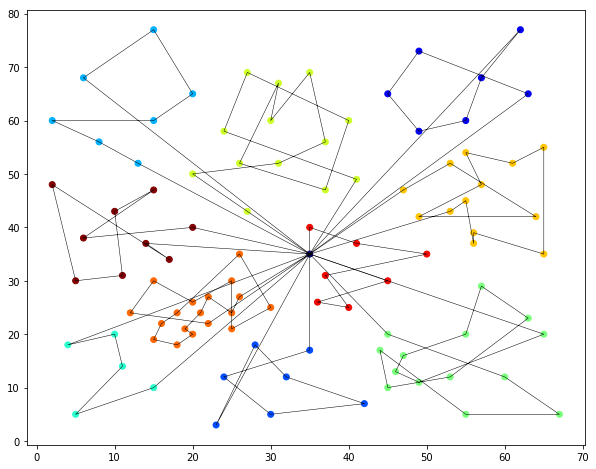

    Instance RC105



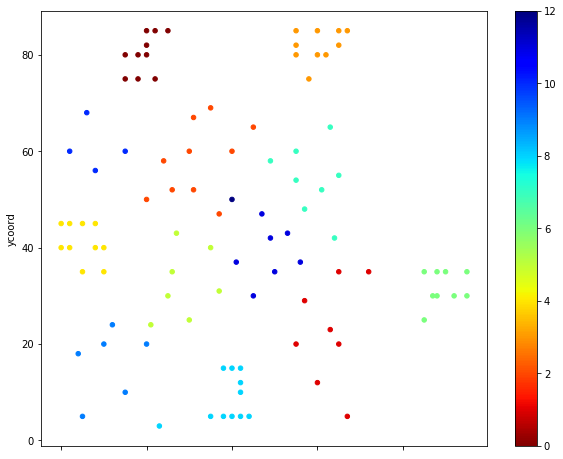


    Initial solution: 
        number of vehicles = 19
        cost = 2040.0549274024377
        feasible = True
    
    Initial graph


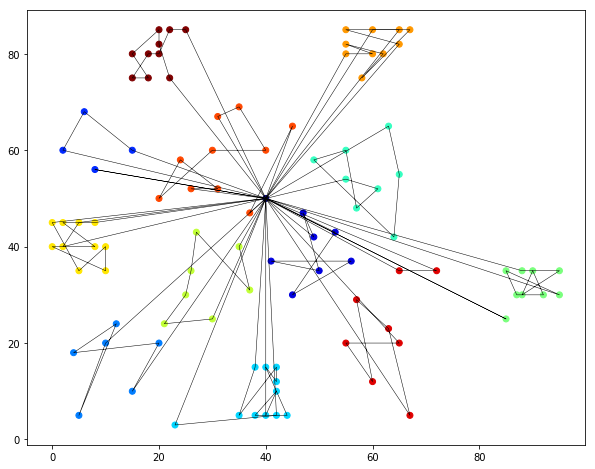

    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1982.0959263081647
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1977.944560556046
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1982.6470526949636
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1982.0959263081647
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1982.6470526949636
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1972.2181711163978
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1982.6470526949636
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1982.0959263081647
    Perturbing...
    Local minimum is reached
    Search

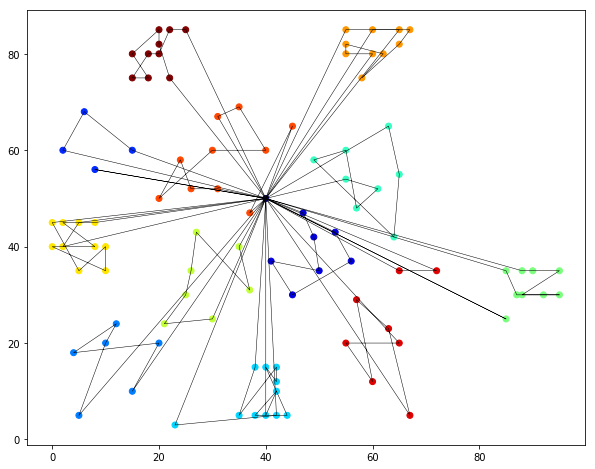

    Instance rc1_4_8



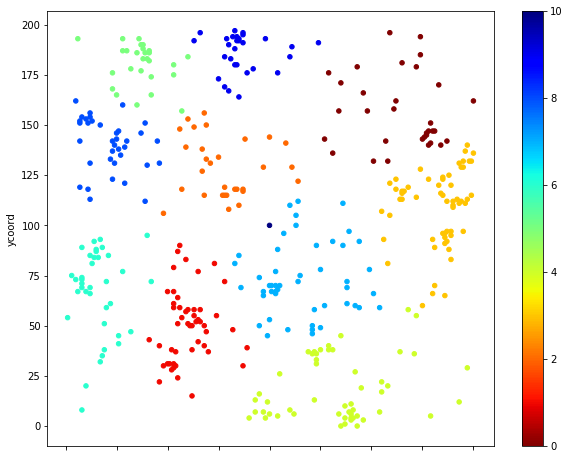


    Initial solution: 
        number of vehicles = 42
        cost = 12703.812611815392
        feasible = True
    
    Initial graph


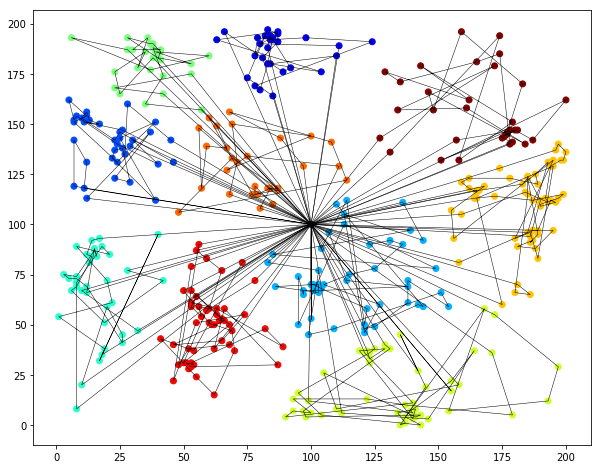

    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 12295.282251246239
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 12235.78542080459
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 12327.616305004347
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 12200.289957037967
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 12264.393424131604
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 12221.802779264845
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 12361.216057088077
    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 12221.802779264845
    Perturbing...
    Local minimum is reached
    Search

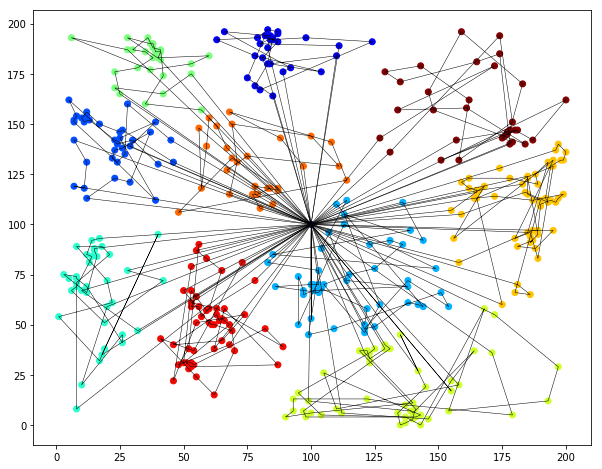

    Instance RC207



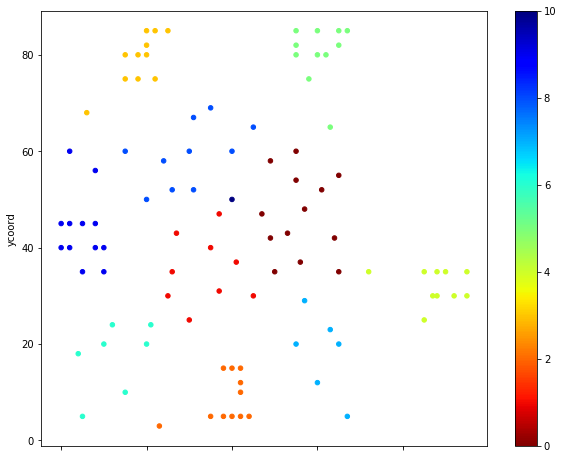


    Initial solution: 
        number of vehicles = 10
        cost = 1660.1612834445004
        feasible = True
    
    Initial graph


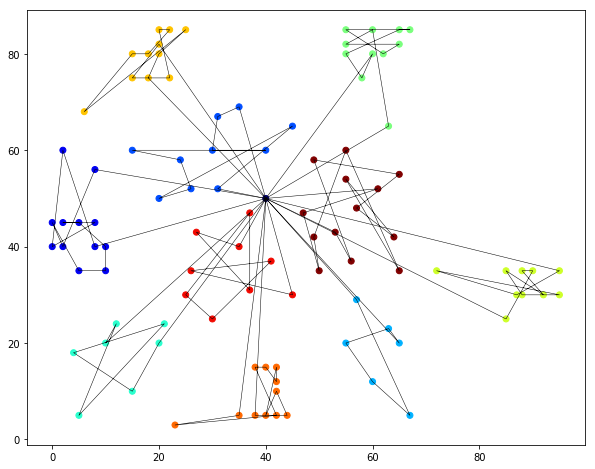

    Perturbing...
    Local minimum is reached
    Search ended after 1 iterations, current cost = 1310.6189190317132
    Perturbing...
    Search ended after 3 iterations, current cost = 1303.8338876914174
    Perturbing...
    Local minimum is reached
    Search ended after 4 iterations, current cost = 1312.270807709636
    Perturbing...
    Local minimum is reached
    Search ended after 4 iterations, current cost = 1312.270807709636
    Perturbing...
    Local minimum is reached
    Search ended after 4 iterations, current cost = 1312.270807709636
    Perturbing...
    Local minimum is reached
    Search ended after 4 iterations, current cost = 1312.270807709636
    Perturbing...
    Local minimum is reached
    Search ended after 4 iterations, current cost = 1312.270807709636
    Perturbing...
    Local minimum is reached
    Search ended after 2 iterations, current cost = 1331.157554136182
    Perturbing...
    Local minimum is reached
    Search ended after 2 iterations, current

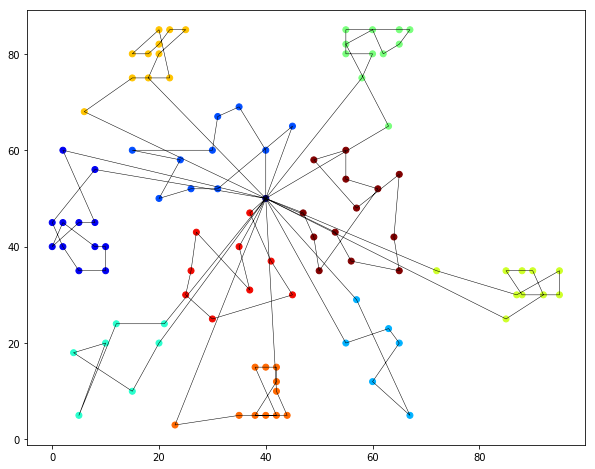

In [5]:
import glob
import scipy
import matplotlib.pyplot as plt
import joblib
import numpy as np
import VRPSolver
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')
instances = glob.glob('./instances/*.txt')
cluster_size = {'C108': 10, 'C203':3, 'C249': 15, 'R168': 10, 'R146': 10, 'C266': 8,
                'R202': 10, 'RC105': 12, 'RC148': 10, 'RC207': 10}

def save_solution(solution, slv):
    def unload_and_move(i, j, arrival):
        return arrival[i] + slv.service[i] + slv.dist(i, j)

    answer = ''
    arrival = np.zeros(slv.df.shape[0])
    for route in solution[:]:
        for i, client in enumerate(route[:-2]):
            next_client = route[i+1]
            arrival[next_client] = np.max([unload_and_move(client, next_client, arrival), slv.opened[next_client]])
        route_arrivals = arrival[route]
        route_arrivals[-1] = unload_and_move(route[-2], 0, arrival)
        answer = answer + ' '.join(['{} {}'.format(c, arr) for c, arr in zip(route, route_arrivals)]) + '\n'

    with open('./sol/{}.sol'.format(instance.split('.')[-2].split('\\')[-1]), 'w') as f:
        print(answer, file=f)

        
def plot_solution(sol):
    plt.figure(figsize=(10,8))
    plt.scatter(slv.df.xcoord, slv.df.ycoord, c=slv.df.cluster, cmap='jet_r')
    for route in sol:
        plt.plot(slv.df.xcoord[route], slv.df.ycoord[route], linewidth=0.5, color='black')
    plt.show()


for instance in instances[:]:
    name = instance.split('.')[-2].split('\\')[-1]
    slv = VRPSolver.VRPSolver(instance, cluster_size[name], 8)
    print("    Instance {}".format(slv.name))
    slv.df.plot.scatter(0, 1, c=slv.df.cluster, colormap='jet_r', figsize=(10,8))
    plt.show()
    
    n_vehicles, initial_solution, cost = slv.get_initial_solution(0)
    print(
    """
    Initial solution: 
        number of vehicles = {}
        cost = {}
        feasible = {}
    """.format(n_vehicles, cost, slv.is_solution_feasible(initial_solution))
    )
    
    print('    Initial graph')
    plot_solution(initial_solution)

    with joblib.Parallel(1) as parallel:
        solution = IteratedLocalSearch(initial_solution, parallel, slv)
    
    save_solution(solution, slv)
    
    print('    Graph after local search')
    plot_solution(solution)